In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from loader import FeatureLoader
from model import AttentionMIL

In [2]:
def evaluate(model, dataloader, device):
    
    y_true = []
    y_pred = []
    
    model.eval()

    with torch.no_grad():

        for data in dataloader:

            X = data['X'].to(device)
            Y = data['Y'].to(device)

            # Forward pass
            P, A = model(X)
            P = F.softmax(P, dim=-1)
                        
            y_true.append(Y.cpu().numpy())
            y_pred.extend(P.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
        
    return y_true, y_pred

In [3]:
def main(config):
    
    print(f'\nFold-{config["fold"]} ...', flush=True)

    # Arange files and labels
    files = sorted(glob.glob(f'{config["data_dir"]}/*.h5'))
    labels = np.array([int(f.split('/')[-1][5]) for f in files]) - 1

    # K-Fold Split
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    _, valid_indices = list(skf.split(files, labels))[config["fold"]]
    valid_samples = [{"X": files[i], "Y":labels[i]} for i in valid_indices]

    # Create dataset
    valid_ds = FeatureLoader(valid_samples)
    valid_ds = DataLoader(valid_ds, batch_size=None, shuffle=False, pin_memory=True)

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Create model
    model = AttentionMIL(feature_size=1024, classes=3).to(device)

    # Load weights
    checkpoint_path = f'{config["model_dir"]}/model_f{config["fold"]}.pt'
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['state_dict'])

    # Evaluating
    y_true, y_pred = evaluate(model, valid_ds, device)
    print(f'Complete!')
    
    return y_true, y_pred

In [4]:
if __name__ == "__main__":
    
    y_true_list = [] 
    y_pred_list = [] 
        
    for fold in range(5):

        config = {
            "data_dir": '/mnt/scratch/crc/data/features/features_0512',
            "model_dir": '/mnt/scratch/crc/models/models_0512',
            "save_dir": '/mnt/scratch/crc/outputs/outputs_0512',
            "fold": fold,
            "seed": 0,
        }

        if not os.path.exists(config["save_dir"]):
            os.makedirs(config["save_dir"])
            
        y_true, y_pred = main(config)
        
        y_true_list.append(y_true)
        y_pred_list.append(y_pred)        


Fold-0 ...
Complete!

Fold-1 ...
Complete!

Fold-2 ...
Complete!

Fold-3 ...
Complete!

Fold-4 ...
Complete!


In [5]:
y_true_combined = []
y_pred_combined = []

for fold in range(5):
    
    print(f'\nFold-{fold} ...\n', flush=True)
    
    y_true = y_true_list[fold]
    y_pred = y_pred_list[fold]
    
    print(classification_report(y_true, np.argmax(y_pred, -1), output_dict=False))
    print('\n\n')
    
    y_true_combined.extend(y_true)
    y_pred_combined.extend(y_pred)
    
print(f'\nCombined ...\n', flush=True)
print(classification_report(y_true_combined, np.argmax(y_pred_combined, -1), output_dict=False))


Fold-0 ...

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        24
         1.0       1.00      1.00      1.00        24
         2.0       1.00      1.00      1.00        12

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60





Fold-1 ...

              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98        24
         1.0       0.96      1.00      0.98        24
         2.0       1.00      1.00      1.00        12

    accuracy                           0.98        60
   macro avg       0.99      0.99      0.99        60
weighted avg       0.98      0.98      0.98        60





Fold-2 ...

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        24
         1.0       0.96      0.96      0.96        24
         2.0       0.92      0

In [6]:
cm = confusion_matrix(y_true_combined, np.argmax(y_pred_combined, -1))

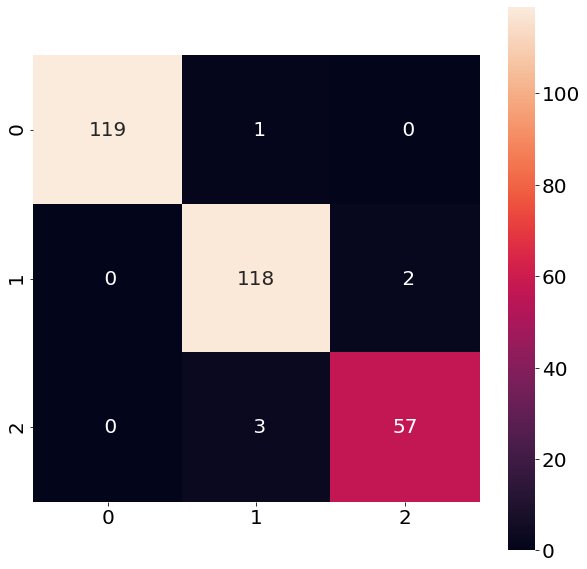

In [7]:
plt.rcParams.update({'font.size': 20})

fig = plt.figure(figsize=(10,10))
fig.patch.set_facecolor('#ffffff')

_ = sns.heatmap(cm, 
                cmap=None, 
                annot=True, 
                fmt='2g', 
                cbar=True, 
                square=True)

plt.savefig(f'{config["save_dir"]}/cm.png', bbox_inches='tight')
plt.show()